# Make a virtual buoy with satellite data  
## Background
There are buoys in many locations around the world that provide data streams of oceanic and atmospheric parameters. The data are often available through data centers like the those National Data Buoy Center (NDBC https://www.ndbc.noaa.gov) and ARGO floats program (http://www.argo.ucsd.edu). Despite these impressive efforts to monitor environmental conditions, in situ buoy data may not be available for your area of interest. Some locations are hard to access, making deploying and maintaining a buoy impractical. In addition, buoys are expensive to purchase, deploy and maintain. Therefore, limited funding may  prevent installation of a buoy in the first place or the continued operation of a buoy already in place.  

Using satellite data to create virual buoys can provide a solution to monitoring surface environmental conditions at locations where it is not feasible to install a buoy. For example, the University of South Florida has developed a virtual buoy system for locations off the Florida coast (https://optics.marine.usf.edu/projects/vbs.html).  

## Objectives 
The following exercise will demonstrate the use of the ERDDAP data server to create a virtual buoy. For the scenario, we will envision that a virtual buoy is need to continue the datastream for an *in situ* buoy that was discontinued at the end of 2019. For this exercise we will use the National Data Buoy Center (NDBC) buoy # 46259, which is located off the California coast at 34.767N latitude and -121.497E longitude, and pretend that it was discontinued at the end of 2019. The buoy measures several oceanic variables, but we will continue the sea surface temperature (SST) datastream using NOAA GeoPolar Blended SST satellite dataset.    
 


## The tutorial demonstrates the following skills:

* __The use of ERDDAP to create a virtual buoy__      
* __The use of the pandas and xarray modules to import and manipulate data__  
* __Resampling data to bin into a lower resolution timestep__ 
* __Generating a linear regression and statistics__
* __Plotting timeseries data__  
* __Cleaning data to remove outlying data points__  

## Datasets used


__NDBC Buoy Data__  
The National Data Buoy Center (NDBC) distributes meteorological data from
moored buoys maintained by NDBC and others. They are deployed in the coastal and offshore waters
from the western Atlantic to the Pacific Ocean around Hawaii, and from the
Bering Sea to the South Pacific. For this tutorial we will use buoy number 46259. NDBC are available from the CoastWatch West Coast Node ERDDAP.  
https://coastwatch.pfeg.noaa.gov/erddap/tabledap/cwwcNDBCMet

## Import require modules

In [1]:
import numpy as np
import xarray as xr
from datetime import datetime
import os
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.metrics import r2_score

# the %matplotlib is a magic function allow displaying results in notebooks
%matplotlib inline

# some tools for Pandas to work will with matplotlib
from pandas.plotting import register_matplotlib_converters


## A note about tabledap
Most of our examples in this course used gridded dataset. The NDBC data for this tutorial is a tabular dataset, served via the tabledap part of ERDDAP. The API for tabledap is a little different than for gridded datasets. You can go to the following URL and play around with subsetting. Then push the "Just generate the URL" button, copy the link, put it in a browser. See if you get what you expected.
https://coastwatch.pfeg.noaa.gov/erddap/tabledap/cwwcNDBCMet  

__A quick primer is below__

The data request URL has thre parts:
1. Base URL: `https://url/erddap/tabledap/datasetID.fileType? ` 
* e.g. https://coastwatch.pfeg.noaa.gov/erddap/tabledap/cwwcNDBCMet.csv?

2. A list of variables you want to download that are separated by commas   
* e.g. station,longitude,latitude,time,wtmp

3. A list of constraints, each starting with an ampersand (&).
* The constraints use =, >, >=, <, and <= to subset the data
* e.g. &station="46259", mean station # 46259
* e.g. &time>=2017-01-01T&time<=2020-12-31', means time between and including Jan. 1, 2017 and Dec. 31, 2020.

The data request URL we will use for the NDBC data:  
`ndbc_url = 'https://coastwatch.pfeg.noaa.gov/erddap/tabledap/cwwcNDBCMet.csv?station,longitude,latitude,time,wtmp&station="46259"&time>=2017-01-01T&time<=2020-12-31`

## Download the data into a Pandas dataframe

In [2]:
# Break the url into part and rejoin it so that it is easier to see.
ndbc_url = ''.join(['https://coastwatch.pfeg.noaa.gov/erddap/tabledap/cwwcNDBCMet.csv?',
                    'station,longitude,latitude,time,wtmp',
                    '&station="46259"&time>=2018-01-01&time<=2019-12-31'
                    ])

req = requests.get(ndbc_url).content
buoy_df = pd.read_csv(io.StringIO(req.decode('utf-8')), skiprows=[1], parse_dates=['time'])
buoy_df.head(2)

,station,longitude,latitude,time,wtmp
0,46259,-121.664,34.732,2018-01-01 00:22:00+00:00,14.6
1,46259,-121.664,34.732,2018-01-01 00:52:00+00:00,14.6


### Extract the longitude and latitude coordinates for the station
After, clean up the dataframe by deleting unneeded columns.

In [3]:
buoy_lat = buoy_df.latitude[0]
buoy_lon = buoy_df.longitude[0]

# Clean up the dataset by removing unneeded columns
del buoy_df['station']
del buoy_df['latitude']
del buoy_df['longitude'] 

print('latitude', buoy_lat)
print('longitude', buoy_lon)

latitude 34.732
longitude -121.664


## Process the buoy data
The measurement rate of the buoy is on the order of minutes. We need downsample the dataset to the daily resolution of the satellite dataset.   

There are a few cleanup steps that are needed:  
* The time data are associated with the UTC time zone. Panda operations often don't like that so let get rid of it. 
* Rename the SST variable to something more intuitive

In [4]:
print('# of timesteps before =', buoy_df.shape[0] )

# The resampling will put time as the df index
buoy_df_resampled = buoy_df.resample('D', on='time').mean()
print('# of timesteps after =', buoy_df_resampled.shape[0] )

# Remove the timezone (UTC, GMT).
buoy_df_resampled = buoy_df_resampled.tz_localize(None)

# Rename the SST variable
buoy_df_resampled.rename(columns={"wtmp": "sst_buoy"}, errors="raise", inplace=True)
buoy_df_resampled

buoy_df_resampled.head(2)

# of timesteps before = 34455
# of timesteps after = 730


,sst_buoy
time,
2018-01-01,14.679167
2018-01-02,14.891489


## Load the satellite data into xarray and subset

In [5]:
# Put satellite data xarray dataset object
sst_url = 'https://coastwatch.noaa.gov/erddap/griddap/noaacwBLENDEDCsstDaily'
sst_ds = xr.open_dataset(sst_url)

# Subset the dataset
sst_ds_subset = sst_ds['analysed_sst'].sel(latitude=buoy_lat,
                            longitude = buoy_lon, method='nearest'
                            ).sel(time=slice('2018-01-01', 
                                             '2019-12-31'
                                             ))

sst_ds_subset

<xarray.DataArray 'analysed_sst' (time: 692)>
[692 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01T12:00:00 ... 2019-12-31T12:00:00
    latitude   float32 34.72
    longitude  float32 -121.7
Attributes:
    colorBarMaximum:  35.0
    colorBarMinimum:  0.0
    comment:          nighttime analysed SST for each ocean grid point
    ioos_category:    Temperature
    long_name:        analysed sea surface temperature
    references:       Fieguth,P.W. et al. "Mapping Mediterranean altimeter da...
    standard_name:    sea_surface_foundation_temperature
    units:            degree_C

## Process the satellite data to make in compatible with the buoy data
* Put the satellite data into a Pandas dataframe
* Resample the data to daily bins - The data is already daily, but resampling this makes the timestamp format the same as the buoy data and make time the index column of the dataframe. 
* Remove the timezone localization from time

In [6]:
# Initialize data of lists.
sat_data = {'time': sst_ds_subset.time.values,
            'sst_sat': sst_ds_subset.to_numpy()
            }

# Creates pandas DataFrame.
sat_df = pd.DataFrame(sat_data)

# Resample
sat_df = sat_df.resample('D', on='time').mean()

# Remove timezone
sat_df = sat_df.tz_localize(None)


sat_df.head(2)

,sst_sat
time,
2018-01-01,14.18
2018-01-02,14.76


## Merge the datasets

In [7]:
merged_df = pd.merge(buoy_df_resampled, 
                     sat_df, 
                     left_index=True, 
                     right_index=True).reset_index()
merged_df.head(2)

,time,sst_buoy,sst_sat
0,2018-01-01,14.679167,14.18
1,2018-01-02,14.891489,14.76


## Plot the data along the same X time axis
The data from the buoy and satellite seem to track each other very well (below). 
* You will want to at least run a linear regression to determine how well satellite data reflects the in situ buoy measurements. 

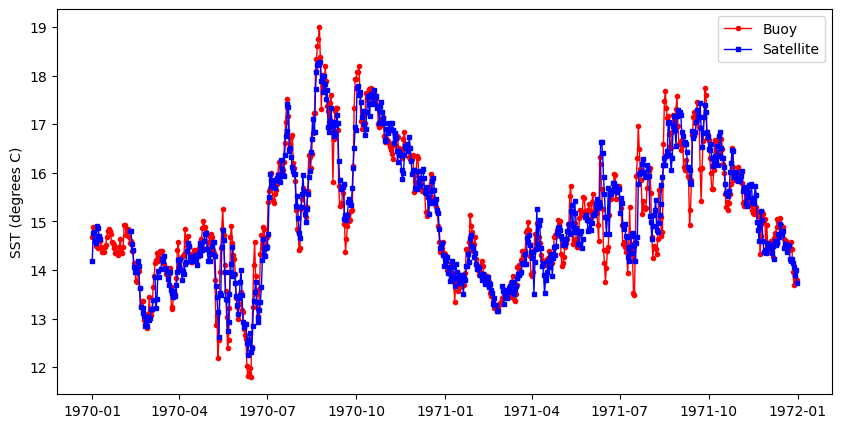

In [8]:
plt.figure(figsize = (10, 5)) 
# Plot the SeaWiFS data
plt.plot_date(merged_df.index, merged_df.sst_buoy, 
              'o', markersize=3, 
              label='Buoy', c='red', 
              linestyle='-', linewidth=1) 

# Add MODIS data
plt.plot_date(merged_df.index, merged_df.sst_sat,  
              's', markersize=3, 
              label='Satellite', c='blue', 
              linestyle='-', linewidth=1) 

#plt.ylim([0, 3])
plt.ylabel('SST (degrees C)') 
plt.legend()

## Clean up the merged dataset
Regression packages typically do not like nan's. 
* Delete rows with nan  

The data could contain data points that are outliers. Let's remove those points from the data frame. 
* Apply a conservative allowable data range. 
    - For the lower end of the range, the freezing point of seawater (ca. -2).  
    - For the high end of the range, value unlikely to be seen in the area of interest (e.g. 45 degrees C). 

In [9]:
# Drop nan
clean_merged_df = merged_df.dropna()

# Drop < -2 and > 45
clean_merged_df = clean_merged_df.drop(clean_merged_df[(clean_merged_df['sst_sat'] < -2) 
                                       | (clean_merged_df['sst_sat'] > 45)].index)

## Run the regression

0.9338037509902803 0.9930764222028932


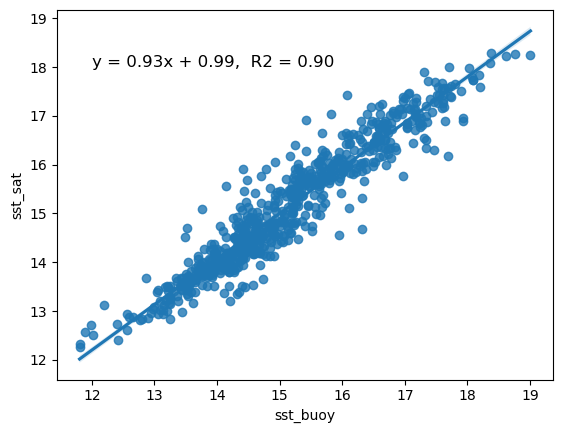

In [10]:
# Regression packages typically do not like nan's. Delete rows with nan
clean_merged_df = merged_df.dropna()

# Generate the regression plot
sns.regplot(x='sst_buoy', y='sst_sat', data=clean_merged_df)

# Calculate the slope and intercept
slope, intercept = np.polyfit(clean_merged_df["sst_buoy"], clean_merged_df["sst_sat"], 1)

# Calculate R2
r2 = r2_score(clean_merged_df["sst_sat"], clean_merged_df["sst_buoy"])

# Annotate the plot
plt.annotate(f"y = {slope:.2f}x + {intercept:.2f},  R2 = {r2:.2f}", 
             xy=(12, 18), 
             #xytext=(30, 5), 
             fontsize=12, 
             color="black", 
             ha="left")

print(slope, intercept)

## It looks like your vitual buoy is ready for operations
* There is essentually a one-to-one relationship between buoy and satellite SST. The slope (0.93) is very close to 1
* The R2 indicates the 90% of the variability of satellite SST is explained by by regression. 

<p style="font-size:30px">CoastWatch Satellite Training Course</p>